# Data analysis 

This notebook takes the filtered data from the data preparation notebook and conducts further analysis

*Author: Koki Sasagawa*  
*Date: 4/10/2019*

In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
files = os.listdir('./temp_data/')
for i, fname in enumerate(files):
    print(i, fname)

0 .DS_Store
1 3-min-water-safety-survey-paid_April 5, 2019_13.26.csv
2 comparisons_US(full_MI).csv
3 comparisons_US(full).csv
4 comparisons_US(full_NON_MI).csv
5 comparisons(mTurk).csv
6 3-min-water-safety-survey_April 6, 2019_11.06.csv
7 comparisons.csv
8 comparisons_US(mTurk).csv
9 NON_US
10 comparisons_US.csv


In [3]:
survey = pd.read_csv('./temp_data/comparisons_US(full).csv', index_col = 0)
print(survey.shape)
survey.head(3)

(109, 33)


,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,LocationLatitude,...,Q7_5,Q7_6,Q7_6_TEXT,Q8,Q9,Q10,Q11,address,country,state
0,2019-03-31 16:57:20,2019-03-31 17:01:08,IP Address,35.2.149.130,100,228,True,2019-03-31 17:01:08,R_1IK0hEA0Mide4IB,42.306793,...,Extremely Important,NaN,NaN,Between 11 to 15 cups,Sedan,Under 20 miles / under 32 km,When I stop every time!!!,"Thurston, Ann Arbor, MI, United States",USA,MI
1,2019-03-31 17:02:24,2019-03-31 17:04:10,IP Address,35.1.136.17,100,106,True,2019-03-31 17:04:11,R_2AKgAVgBovymcHp,42.306793,...,Important,NaN,NaN,Between 1 to 5 cups,I do not drive,NaN,NaN,"Thurston, Ann Arbor, MI, United States",USA,MI
2,2019-03-31 16:58:11,2019-03-31 17:04:48,IP Address,35.1.88.101,100,397,True,2019-03-31 17:04:49,R_1f8Jsm0KyK8p4hl,42.306793,...,Important,NaN,NaN,Between 6 to 10 cups,Sedan,Under 20 miles / under 32 km,"When I am driving, I wanna drink it","Thurston, Ann Arbor, MI, United States",USA,MI


## Analyze Q7 reponses on factors impacting water quality

In [4]:
# Check for missing values
survey.isna().sum()

StartDate                 0
EndDate                   0
Status                    0
IPAddress                 0
Progress                  0
Duration (in seconds)     0
Finished                  0
RecordedDate              0
ResponseId                0
LocationLatitude          0
LocationLongitude         0
DistributionChannel       0
UserLanguage              0
Q1                        0
Q2                        0
Q3                        0
Q4                        0
Q5                        0
Q6                        0
Q7_1                      0
Q7_2                      0
Q7_3                      0
Q7_4                      1
Q7_5                      0
Q7_6                     73
Q7_6_TEXT                89
Q8                        0
Q9                        0
Q10                      13
Q11                      18
address                   0
country                   0
state                     0
dtype: int64

We expect Q7_6, Q7_6_TEXT to have some empty responses as these were optional. Q10 and Q11 can also be expected to contain missing values as these questions were not accessible if the driver selected "I do not drive" as a response to Q9. 

Q7_4 should not be missing a response. Since there is only 1 instance of a row with missing values, we will simply omit this row from the data. 

In [5]:
# Get the row index that contains the missing response in Q7_4.
rows = survey[survey['Q7_4'].isna()].index.tolist()
rows

[70]

In [6]:
# Drop this row
# The dimension should have 1 less row than previous 
survey = survey.drop(index=rows, axis=0)
survey.reset_index(drop=True, inplace=True)
print("Dimensions: {}".format(survey.shape))

Dimensions: (108, 33)


In [7]:
Q7_responses = survey[['Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5', 'Q7_6', 'Q7_6_TEXT']]
print("Dimensions: {}".format(Q7_responses.shape))

Dimensions: (108, 7)


In [8]:
Q7_responses.head()

,Q7_1,Q7_2,Q7_3,Q7_4,Q7_5,Q7_6,Q7_6_TEXT
0,Important,Extremely Important,Important,Extremely Important,Extremely Important,NaN,NaN
1,Important,Extremely Important,Important,Extremely Important,Important,NaN,NaN
2,Extremely Important,Extremely Important,Important,Extremely Important,Important,NaN,NaN
3,Extremely Important,Somewhat Important,Somewhat Important,Extremely Important,Important,Important,Myths/gossip about places with better/worse water
4,Important,Somewhat Important,Somewhat Not Important,Somewhat Important,Neutral,NaN,NaN


### Analyze themes that users felt were important

In [9]:
# Separate out the free text box responses
Q7_optional = Q7_responses[['Q7_6', 'Q7_6_TEXT']]
Q7_optional.dropna(inplace=True)
print("Dimensions: {}".format(Q7_optional.shape))
Q7_optional.reset_index(drop=True, inplace=True)
Q7_optional.columns = ['Other (please specify)', 'Textbox Entry']


# sort by specified order
Q7_optional['Other (please specify)'] = pd.Categorical(Q7_optional['Other (please specify)'], categories=['Extremely Important', 
                                                                                                          'Important',
                                                                                                          'Somewhat Important',
                                                                                                          'Neutral',
                                                                                                          'Somewhat Not Important',
                                                                                                          'Not Important',
                                                                                                          'Extremely Not Important'])
# sort
Q7_optional = Q7_optional.sort_values('Other (please specify)')
Q7_optional

Dimensions: (17, 2)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Other (please specify),Textbox Entry
1,Extremely Important,sustainability
13,Extremely Important,water ph
3,Extremely Important,Water taste.
4,Extremely Important,Whether the water was filtered/treated or not
9,Extremely Important,Taste
0,Important,Myths/gossip about places with better/worse water
12,Important,"if it is bottled, how old it is"
10,Important,Taste
16,Important,Taste
6,Important,Source depletion


### Analyze how factors compared rank among eachother

In [10]:
factors = Q7_responses[['Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5']]
factors.columns = ['Water source', 'Testing of water quality', 'Government water regulations', 
                   'Local water pollution level', 'News impacting water safety']
factors.reset_index(drop=True, inplace=True)
print(factors.shape)
factors.head()

(108, 5)


,Water source,Testing of water quality,Government water regulations,Local water pollution level,News impacting water safety
0,Important,Extremely Important,Important,Extremely Important,Extremely Important
1,Important,Extremely Important,Important,Extremely Important,Important
2,Extremely Important,Extremely Important,Important,Extremely Important,Important
3,Extremely Important,Somewhat Important,Somewhat Important,Extremely Important,Important
4,Important,Somewhat Important,Somewhat Not Important,Somewhat Important,Neutral


In [11]:
for i in factors.columns:
    factors[i] = factors[i].map({"Extremely Important": 7,
                                 "Important": 6,
                                 "Somewhat Important": 5,
                                 "Neutral": 4,
                                 "Somewhat Not Important": 3,
                                 "Not Important": 2,
                                 "Extremely Not Important": 1})

factors.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Water source,Testing of water quality,Government water regulations,Local water pollution level,News impacting water safety
0,6,7,6,7,7
1,6,7,6,7,6
2,7,7,6,7,6
3,7,5,5,7,6
4,6,5,3,5,4


In [16]:
# Generate subplot grid coordinates
axis_keys = [] 
for i in list(range(5)):
    axis_keys.append((i))

axis_keys[:5]

[0, 1, 2, 3, 4]

In [17]:
# Map column to grid coordinates
subplot_data = {}
for i, v in enumerate(factors):
    subplot_data[v] = axis_keys[i]

subplot_data

{'Water source': 0,
 'Testing of water quality': 1,
 'Government water regulations': 2,
 'Local water pollution level': 3,
 'News impacting water safety': 4}

In [18]:
colors = ['deepskyblue', 'lightgreen', 'coral', 'gold', 'plum']

In [21]:
np.arange(0,8)

array([0, 1, 2, 3, 4, 5, 6, 7])

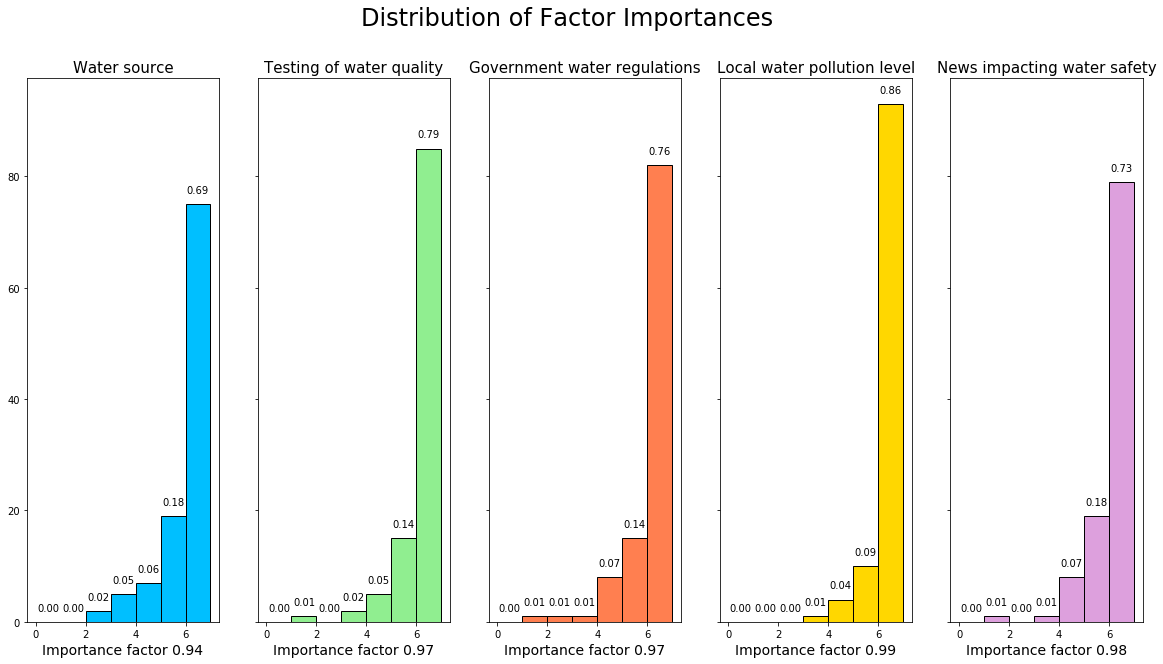

In [25]:
fig, ax = plt.subplots(figsize=(20,10), nrows=1, ncols=5, sharey=True)
fig.suptitle('Distribution of Factor Importances', fontsize=24)

for k, v in subplot_data.items():
    ax[v].hist(factors[k], bins=np.arange(0,8), color=colors[v], edgecolor='black')
    ax[v].set_title(k, fontsize=15)
    
    y = [] 
    for rects in ax[v].patches:
        # y-axis value 
        height = rects.get_height()
        y.append(height)
        ax[v].text(rects.get_x()+rects.get_width()/2.0,
                   height+2, 
                   '{:1.2f}'.format(height/factors.shape[0]),
                   ha='center')
    
    pos_score = sum(y[-3:])/factors.shape[0]
    ax[v].set_xlabel('Importance factor {:1.2f}'.format(pos_score), fontsize=14)


fig = plt.gcf() # get current figure
fig.savefig("./images/Factors.png")
plt.show()

In [82]:
violin = pd.melt(factors, id_vars='index', value_vars=['Water source', 'Testing of water quality', 'Government water regulations', 
                   'Local water pollution level', 'News impacting water safety'])

violin.replace({"value": {
                          "Extremely Important": 7,
                          "Important": 6,
                          "Somewhat Important": 5,
                          "Neutral": 4,
                          "Somewhat Not Important": 3,
                          "Not Important": 2,
                          "Extremely Not Important": 1}}, inplace=True)
violin.columns = ['index', 'Factors', 'Values']
violin.head()

,index,Factors,Values
0,0,Water source,6.0
1,1,Water source,6.0
2,2,Water source,6.0
3,3,Water source,7.0
4,4,Water source,7.0


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

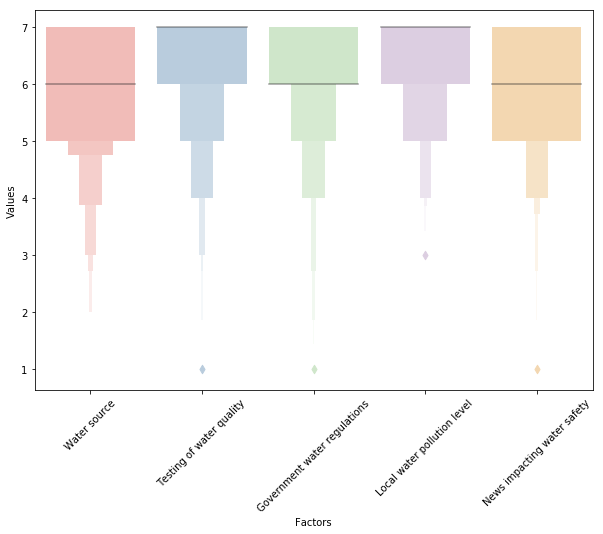

In [85]:
plt.figure(figsize=(10,7))
sns.boxenplot(x="Factors", y="Values", data=violin, palette="Pastel1")
plt.xticks(rotation=45)

In [93]:
# g = sns.FacetGrid(violin, row="Factors")
# g.map(plt.hist, 'Values')

In [46]:
factors['Water source'].value_counts()

Important                 43
Extremely Important       35
Somewhat Important        19
Neutral                    7
Somewhat Not Important     5
Not Important              2
Name: Water source, dtype: int64

In [50]:
important = [] 
e_important = []
x = factors.columns 

for i in factors.columns:

    important.append(factors[i].value_counts().loc['Important'])
    e_important.append(factors[i].value_counts().loc['Extremely Important'])

In [51]:
print("important", important)
print("extremely important", e_important) 
print("somewhat importamt", s_important)
print('neutral', neutral)
print('Some')

[43, 30, 45, 27, 43]

[35, 58, 40, 68, 38]

In [58]:
combined_height = np.add(important, e_important).tolist()
combined_height

[78, 88, 85, 95, 81]

<BarContainer object of 5 artists>

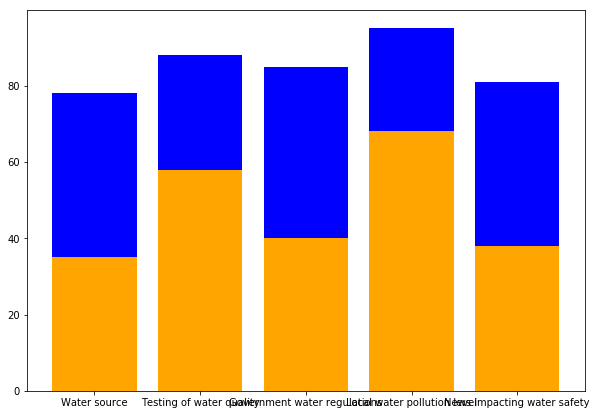

In [60]:
plt.figure(figsize=(10,7))
plt.bar(x, e_important, color='orange')
plt.bar(x, important, bottom=e_important, color='blue')
plt.bar(x, )


In [45]:
factors['Water source'].value_counts().loc['Important']
factors['Water source'].value_counts().loc['Extremely Important']

43

<BarContainer object of 6 artists>

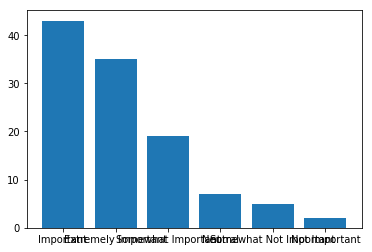

In [40]:
y = filtered['Q7_1'].value_counts().values
x = filtered['Q7_1'].value_counts().index
plt.figure(fig)
plt.bar(x,y)